# Question 1.1

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [23]:
df = pd.read_csv('A1_co2.txt', sep=" ")
df.head()

,year,month,time,co2
0,1958,3,1958.208,315.71
1,1958,4,1958.292,317.45
2,1958,5,1958.375,317.50
3,1958,6,1958.458,317.10
4,1958,7,1958.542,315.86


> You should not use the observations for years 2018 and 2019 (Last 20 observations) for estimations/training - only for comparisons/testing.

In [24]:
# Let the train set be the measurements before 2018, and the test set be the measurements after 2018
train = df[df['year'] < 2018]
test = df[df['year'] >= 2018]

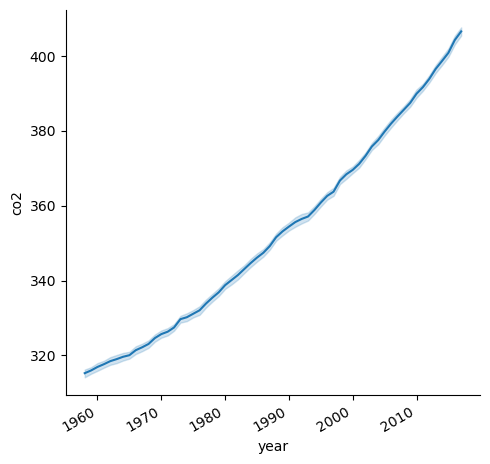

In [25]:
# TODO: Plot test and train set together

# Plot the train set
g = sns.relplot(x="year", y="co2", kind="line", data=train)
g.fig.autofmt_xdate()


# Question 1.2

## Question 1.2.1

In [26]:
MONTHS_IN_YEAR = 12

X = np.vstack(
    [
        np.ones_like(train["time"]),
        train["time"],
        np.sin(2 * np.pi / MONTHS_IN_YEAR * (train["month"] - 1)),
        np.cos(2 * np.pi / MONTHS_IN_YEAR * (train["month"] - 1)),
    ]
).T

In [27]:
y = train["co2"].values

In [28]:
beta_hat, _, _, _ = np.linalg.lstsq(X, y)
beta_hat

/var/folders/p_/6wwjz4v11fs26vb5j8zwskgm0000gn/T/ipykernel_65732/2767225113.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  beta_hat, _, _, _ = np.linalg.lstsq(X, y)


array([-2.70966921e+03,  1.54048858e+00,  2.79666606e+00, -3.37828870e-01])

## Question 1.2.2

In [29]:
N, p = X.shape

residuals = y - X @ beta_hat

sigma_hat2 = np.sum(residuals ** 2) / (N - p)
sigma_hat2

12.185006902038825

In [30]:
beta_hat_var = sigma_hat2 * np.linalg.inv(X.T @ X)
beta_hat_var

array([[ 2.24882564e+02, -1.13106724e-01, -3.04580858e-02,
         8.25588856e-03],
       [-1.13106724e-01,  5.68923456e-05,  1.53322444e-05,
        -4.10820940e-06],
       [-3.04580858e-02,  1.53322444e-05,  3.38749771e-02,
         3.99555742e-05],
       [ 8.25588856e-03, -4.10820940e-06,  3.99555742e-05,
         3.40133872e-02]])

<AxesSubplot: >

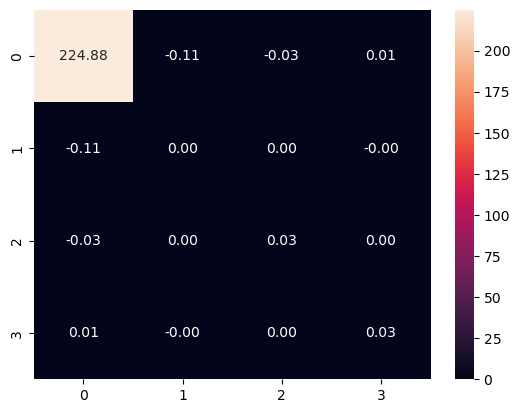

In [31]:
# Heatmap of the variance of the coefficients
sns.heatmap(beta_hat_var, annot=True, fmt=".2f")

## Question 1.2.3

/var/folders/p_/6wwjz4v11fs26vb5j8zwskgm0000gn/T/ipykernel_65732/2672438754.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


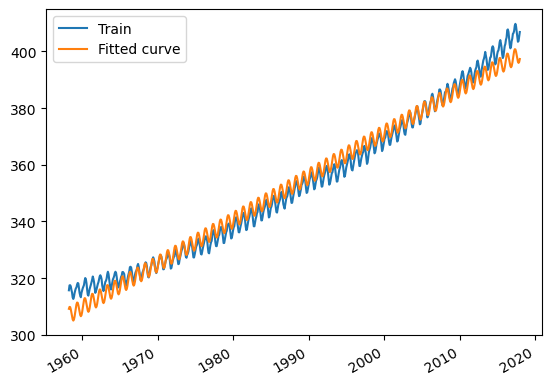

In [32]:
y_hat = X @ beta_hat

# Plot the train set and the fitted curve
fig, ax = plt.subplots()

ax.plot(train["time"], train["co2"], label="Train")
ax.plot(train["time"], y_hat, label="Fitted curve")

ax.legend()

fig.autofmt_xdate()
fig.show()

## Question 1.2.4

Plan-of-attack: Relaxtion algorithm

In [45]:
def rho_matrix(rho: float, n: int):
    """
    Returns the covariance matrix for the observations of a stationary AR(1) process.
    """
    rhos = np.vander([rho], n, increasing=True)
    return scipy.linalg.toeplitz(rhos)


N, p = X.shape

# Initial guess of correlation structure
Sigma = np.eye(N) * sigma_hat2

# Initial guess of coefficients
beta = beta_hat

betas = []

while True:

    # E-step
    Sigma_inv = np.linalg.inv(Sigma)

    P = np.linalg.inv(X.T @ Sigma_inv @ X)  # Precision matrix

    H = P @ X.T @ Sigma_inv
    beta_new = H @ y

    # M-step
    residuals = y - X @ beta_new

    # Calculate 1-lagged autocorrelation
    rho = np.sum(residuals[1:] * residuals[:-1]) / np.sum(residuals**2)
    Sigma_new = rho_matrix(rho, N)

    if np.allclose(beta, beta_new, atol=1e-6):
        break

    beta = beta_new
    Sigma = Sigma_new

    betas.append(beta)

beta

array([-2.70966921e+03,  1.54048858e+00,  2.79666606e+00, -3.37828870e-01])

/var/folders/p_/6wwjz4v11fs26vb5j8zwskgm0000gn/T/ipykernel_65732/1449667870.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


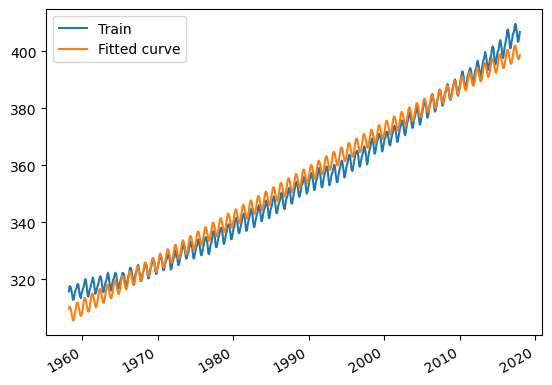

In [36]:
y_hat = X @ beta

# Plot the train set and the fitted curve
fig, ax = plt.subplots()

ax.plot(train["time"], train["co2"], label="Train")
ax.plot(train["time"], y_hat, label="Fitted curve")

ax.legend()

fig.autofmt_xdate()
fig.show()